In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
NIST_PATH = 'all_images/NIST/A_Z Handwritten Data.csv' # Defining the Dataset Path

In [3]:
# Intializing the tensorflow and GPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus >= 1:
    tf.config.experimental.set_memory_growth(gpus[0], True)
else: 
    print(f'GPU not found, Using CPU for tensorflow')

Num GPUs Available:  1


In [4]:
import numpy as np
import cv2

def load_az_dataset(dataset_path):
    # List for storing data
    data = []
    # List for storing labels
    labels = []

    for row in open(dataset_path): #Openfile and start reading each row
        #Split the row at every comma
        row = row.split(",")
        #row[0] contains label
        label = int(row[0])
        #Other all collumns contains pixel values make a saperate array for that
        img = np.array([int(x) for x in row[1:]], dtype="uint8")
        #Reshaping image to 28 x 28 pixels
        img = img.reshape((28, 28))
        #append image to data
        data.append(img)
        #append label to labels
        labels.append(label)

    #Converting data to numpy array of type float32
    data = np.array(data, dtype='float32')
    #Converting labels to type int
    labels = np.array(labels, dtype="int")

    return (data, labels)

In [5]:
(images, labels) = load_az_dataset(NIST_PATH) # Using the fucntion to load the dataset

images = [cv2.resize(image, (32, 32)) for image in images] # Resizing the images to 32 x 32
images = np.array(images, dtype="float32") # Converting to float 32 for tensorflow models

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]

images = np.expand_dims(images, axis=-1) # Adding a Channel dimension as tensorflow models only accpet (H, W, C) or (B, H, W, C)
images /= 255.0 # Normailzing the values from range [0 255] to [0 1]

In [6]:
from sklearn.preprocessing import LabelBinarizer # Importing the Label Binarizer to one hot encode the labels

le = LabelBinarizer() # Calling the function
labels = le.fit_transform(labels) # Fitting the labels and transforming the labels

In [8]:
from sklearn.model_selection import train_test_split # importing the train test split to split the dataset

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2) # splitting the dataset

del images, labels # deleting the old variabel to save RAM

In [9]:
y_train.shape, y_test.shape # Getting a shape to verify/check

((297960, 26), (74491, 26))

In [10]:
# Buidling the model

# Importing the required layer classes
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Dense, Flatten, Input

# Importing the Sequential
from tensorflow.keras import Sequential

# Calling the sequential
model = Sequential()

# Setting up a input to the model and defining the shape of input
model.add(Input(shape=X_train.shape[1:]))

# Adding the main layer
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(units=58, activation='relu'))
model.add(Dense(units=26, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 32, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                      

In [11]:
# Impoting the optimizer
from tensorflow.keras.optimizers import Adam

EPOCHS = 20 # Setting No. of Epochs
BS = 8 # Setting Batch Size

# Defining the optimizer and adding a decay to avoid overfit
opt = Adam(learning_rate=1e-3, decay=1e-3 / EPOCHS)

# Compiling the model
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# Fitting the model with training data and checking the performance with the testing data
history = model.fit(X_train, y_train,
              batch_size = BS,
              validation_data=(X_test, y_test),
              steps_per_epoch=len(X_train) // BS,
              epochs=EPOCHS,
              verbose=1)

Epoch 1/20
37245/37245 [==============================] - 290s 8ms/step - loss: 0.1230 - accuracy: 0.9654 - val_loss: 0.0523 - val_accuracy: 0.9860
Epoch 2/20
37245/37245 [==============================] - 290s 8ms/step - loss: 0.0313 - accuracy: 0.9914 - val_loss: 0.0286 - val_accuracy: 0.9924
Epoch 3/20
37245/37245 [==============================] - 292s 8ms/step - loss: 0.0170 - accuracy: 0.9954 - val_loss: 0.0230 - val_accuracy: 0.9947
Epoch 4/20
37245/37245 [==============================] - 292s 8ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0222 - val_accuracy: 0.9954
Epoch 5/20
37245/37245 [==============================] - 295s 8ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.0193 - val_accuracy: 0.9965
Epoch 6/20
37245/37245 [==============================] - 295s 8ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0206 - val_accuracy: 0.9966
Epoch 7/20
37245/37245 [==============================] - 292s 8ms/step - loss: 0.0013 - accuracy: 0.9996 - val_

In [12]:
model.save('./NIST_MODEL_1.h5') # Saving the model

In [88]:
# Pipeline to load new images for testing
def pred_word_from_image(path, word=False, model_path='./NIST_MODEL_1.h5'):
    #
    import tensorflow as tf
    import cv2
    import matplotlib.pyplot as plt
    #
    label_letter_dict = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e',
                        5:'f', 6:'g', 7:'h', 8:'i', 9:'j',
                        10:'k', 11:'l', 12:'m', 13:'n', 14:'o',
                        15:'p', 16:'q', 17:'r', 18:'s', 19:'t',
                        20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25:'z'}
    #
    if word:
        pred_word = []
        for i in path:
            img = cv2.imread(i, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.bitwise_not(img)
            plt.imshow(img)
            img = np.expand_dims(img, axis=0)
            img = np.array(img, dtype="float32")
            img /= 255.0
            model = tf.keras.models.load_model(model_path)
            pred = model.predict(img)
            #pred_word.append(label_letter_dict[le.inverse_transform(pred)])
        return pred_word, pred
    else:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.bitwise_not(img)
        plt.imshow(img)
        img = np.expand_dims(img, axis=0)
        img = np.array(img, dtype="float32")
        img /= 255.0
        model = tf.keras.models.load_model(model_path)
        pred = np.argmax(model.predict(img), axis=1)
        pred_letter = label_letter_dict[pred[0]]
        return pred_letter, pred

1/1 [==============================] - 0s 85ms/step


('b', array([1], dtype=int64))

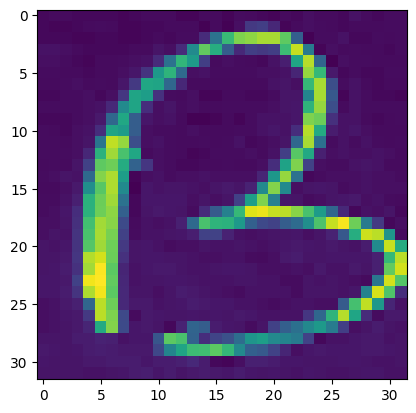

In [121]:
a_path = 'all_images/Cropped_Images/B_002.jpg'
pred_word_from_image(a_path)